Transfer learning / fine-tuning (Aprendizado por transferência / ajuste fino)
Este tutorial irá guiá-lo pelo processo de usar transfer learning (aprendizado por transferência) para treinar um classificador de imagens preciso a partir de um número relativamente pequeno de amostras de treino. De modo geral, aprendizado por transferência se refere ao processo de aproveitar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada com bom desempenho em um conjunto de dados maior, e usá-la como base para um novo modelo que aproveita a precisão da rede anterior para uma nova tarefa. Esse método se tornou popular nos últimos anos para melhorar o desempenho de redes neurais treinadas com conjuntos de dados pequenos; a intuição é que o novo conjunto de dados pode ser pequeno demais para alcançar um bom desempenho por conta própria, mas sabemos que a maioria das redes neurais treinadas para aprender características visuais geralmente aprende características semelhantes de qualquer forma, especialmente nas camadas iniciais, onde elas são mais genéricas (detectores de bordas, formas, etc.).

O aprendizado por transferência foi amplamente viabilizado pela disponibilização pública de modelos de última geração; para os modelos com melhor desempenho em tarefas de classificação de imagens (como os do ILSVRC: http://www.image-net.org/challenges/LSVRC/), é prática comum atualmente não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que iniciantes usem esses classificadores de imagem de ponta para melhorar o desempenho de seus próprios modelos específicos de tarefa.

Extração de características vs. ajuste fino
Em um extremo, o aprendizado por transferência pode envolver pegar a rede pré-treinada e congelar os pesos, utilizando uma de suas camadas ocultas (geralmente a última) como um extrator de características, usando essas características como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente da última camada ou das últimas camadas) sejam modificados. Outro nome para esse procedimento é "fine-tuning" (ajuste fino), pois estamos ajustando levemente os pesos da rede pré-treinada para a nova tarefa. Normalmente treinamos essa rede com uma taxa de aprendizado menor, já que esperamos que as características já sejam razoavelmente boas e não precisem de muitas alterações.

Às vezes, fazemos algo intermediário: congelamos apenas as camadas iniciais/genéricas, mas fazemos ajuste fino nas camadas finais. Qual estratégia é melhor depende do tamanho do seu conjunto de dados, do número de classes, e de quão semelhante ele é ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se ele pode se beneficiar dos mesmos extratores de características aprendidos). Uma discussão mais detalhada sobre como definir a melhor estratégia pode ser encontrada em [1: http://cs231n.github.io/transfer-learning/] [2: http://sebastianruder.com/transfer-learning/].

Procedimento
Neste guia, vamos passar pelo processo de carregar um classificador de imagens com 1000 classes de última geração, o VGG16 (https://arxiv.org/pdf/1409.1556.pdf), que venceu o desafio ImageNet em 2014 (http://www.robots.ox.ac.uk/~vgg/research/very_deep/), e usá-lo como um extrator de características fixo para treinar um classificador personalizado menor com nossas próprias imagens — embora, com poucas alterações no código, você também possa tentar o ajuste fino.

Primeiro, vamos carregar o VGG16 e remover sua camada final, a camada de classificação softmax de 1000 classes específica do ImageNet, e substituí-la por uma nova camada de classificação para as classes que queremos treinar. Em seguida, vamos congelar todos os pesos da rede, exceto os novos que se conectam à nova camada de classificação, e então treinar essa nova camada sobre nosso novo conjunto de dados.

Também vamos comparar esse método com o treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, isso melhorará drasticamente nossa precisão. Faremos essa parte primeiro.

Como exemplo, usaremos um conjunto de dados contendo cerca de 6000 imagens pertencentes a 97 classes, e treinaremos um classificador de imagens com cerca de 80% de precisão sobre ele. Vale observar que essa estratégia escala bem até para conjuntos de imagens onde você pode ter apenas algumas centenas ou menos de imagens. O desempenho será menor com um número pequeno de amostras (dependendo das classes), como de costume, mas ainda assim impressionante considerando as limitações habituais.

In [29]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Obtendo um conjunto de dados
O primeiro passo será carregar nossos dados. Como exemplo, utilizaremos o conjunto de dados CalTech-101 (http://www.vision.caltech.edu/Image_Datasets/Caltech101/), que contém cerca de 9000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, vamos excluir 5 das categorias que possuem mais imagens. Isso é feito para manter a distribuição das classes razoavelmente balanceada (em torno de 50 a 100 imagens por classe) e limitada a um número menor de imagens, cerca de 6000.

Para obter esse conjunto de dados, você pode executar o script de download download.sh na pasta data, ou os seguintes comandos:


wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
tar -xvzf 101_ObjectCategories.tar.gz
Se você desejar usar seu próprio conjunto de dados, ele deve estar organizado da mesma forma que 101_ObjectCategories, com todas as imagens organizadas em subpastas, uma para cada classe. Nesse caso, a célula a seguir deve carregar corretamente seu conjunto de dados personalizado, bastando substituir o valor de root pelo caminho da sua pasta.


Se você tiver uma estrutura alternativa, apenas certifique-se de carregar a lista data, onde cada elemento é um dicionário no qual x é o dado (um array NumPy unidimensional) e y é o rótulo (um número inteiro). Utilize a função auxiliar get_image(path) para carregar corretamente a imagem no array, e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada do VGG16 é uma imagem RGB de 224x224. Você não precisa redimensionar as imagens no seu disco, pois isso já está sendo feito no código abaixo.

Se você tiver a pasta 101_ObjectCategories na sua pasta data, a célula a seguir deverá carregar todos os dados corretamente.

https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset

In [30]:
import zipfile
import os

zip_path = "Cars nd Motorcycles Kaggle.zip"  # nome do seu arquivo zip exato
extract_path = "cars_and_motorcycles"        # nome da pasta para extrair

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))  # para ver o conteúdo extraído

['Car-Bike-Dataset']


In [31]:
# !echo "Downloading 101_Object_Categories for image notebooks"
# !curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
# !tar -xzf 101_ObjectCategories.tar.gz
# !rm 101_ObjectCategories.tar.gz
# !ls


In [32]:
root = "cars_and_motorcycles/Car-Bike-Dataset"
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

# Pega somente as subpastas diretas dentro de root (nomes das classes)
categories = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

# Remove as categorias que estão na lista exclude
categories = [c for c in categories if c not in exclude]

print(categories)

['Car', 'Bike']


Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada.

In [33]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz

In [34]:
data = []

for c, category in enumerate(categories):
    category_path = os.path.join(root, category)

    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category_path) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]

    print(f"Categoria: {category} - Imagens encontradas: {len(images)}")
    print("Alguns arquivos:", images[:5])  # mostra até 5 arquivos

    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x': np.array(x[0]), 'y': c})

num_classes = len(categories)
print(f"Número total de imagens carregadas: {len(data)}")
print(f"Número de classes: {num_classes}")

Categoria: Car - Imagens encontradas: 2000
Alguns arquivos: ['cars_and_motorcycles/Car-Bike-Dataset/Car/Car (603).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Car/Car (1323).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Car/Car (258).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Car/Car (1623).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Car/Car (50).jpeg']
Categoria: Bike - Imagens encontradas: 2000
Alguns arquivos: ['cars_and_motorcycles/Car-Bike-Dataset/Bike/Bike (933).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Bike/Bike (89).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Bike/images (106).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Bike/Bike (852).jpeg', 'cars_and_motorcycles/Car-Bike-Dataset/Bike/images (102).jpeg']
Número total de imagens carregadas: 4000
Número de classes: 2


Randomize the data order.

In [35]:
random.shuffle(data)

criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [36]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados para rótulos.

In [37]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 

Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [38]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(600, 2)


Let's get a summary of what we have.

In [39]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 4000 images from 2 categories
train / validation / test split: 2800, 600, 600
training data shape:  (2800, 224, 224, 3)
training labels shape:  (2800, 2)


Se tudo funcionou corretamente, você deve ter carregado um monte de imagens e dividido-as em três conjuntos: `train`, `val` e `test`. O formato dos dados de treinamento deve ser (`n`, 224, 224, 3), onde `n` é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (`n`, `c`), onde `c` é o número de classes (97 no caso de `101_ObjectCategories`).

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento `train`, um conjunto de validação `val` e um conjunto de teste `test`. O motivo disso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajuste ao conjunto de treinamento. O conjunto `test` é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de exemplo do nosso conjunto de dados.

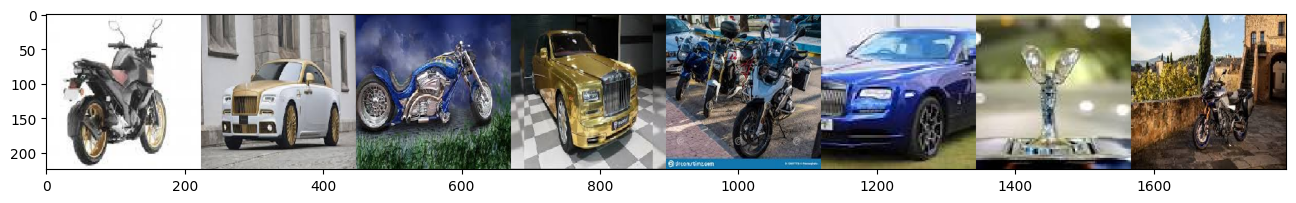

In [40]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Primeiro, treinando uma rede neural do zero

Antes de realizar o aprendizado por transferência, vamos construir uma rede neural do zero para realizar a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência posteriormente.

A rede que construiremos contém 4 camadas convolucionais e de agrupamento máximo alternadas, seguidas por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada par conv/pooling. Após a última camada de agrupamento, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de abandono e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será [AdaDelta](https://arxiv.org/abs/1212.5701). Vários aspectos desta rede podem ser alterados para obter melhor desempenho. Talvez usar uma rede maior ou um otimizador diferente ajude, mas, para os propósitos deste notebook, o objetivo é apenas obter uma base aproximada para fins de comparação, portanto, não é necessário gastar muito tempo tentando otimizar esta rede.

Após compilar a rede, vamos executar `model.summary()` para obter um snapshot de suas camadas.

In [41]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de médio porte com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles leva à camada totalmente conectada pré-softmax "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo posteriormente.

In [42]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 382ms/step - accuracy: 0.5164 - loss: 0.7232 - val_accuracy: 0.6033 - val_loss: 0.6489
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.6182 - loss: 0.6379 - val_accuracy: 0.7717 - val_loss: 0.4608
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.8037 - loss: 0.4567 - val_accuracy: 0.8800 - val_loss: 0.3045
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.8782 - loss: 0.2938 - val_accuracy: 0.8983 - val_loss: 0.2377
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.8954 - loss: 0.2553 - val_accuracy: 0.8850 - val_loss: 0.2757
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8856 - loss: 0.2775 - val_accuracy: 0.9217 - val_loss: 0.1955
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9182 - loss: 0.2067 - val_accuracy: 0.9267 - val_loss: 0.2021
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9308 - loss: 0.1789 - val_accuracy: 

Vamos traçar a perda de validação e a precisão da validação ao longo do tempo.

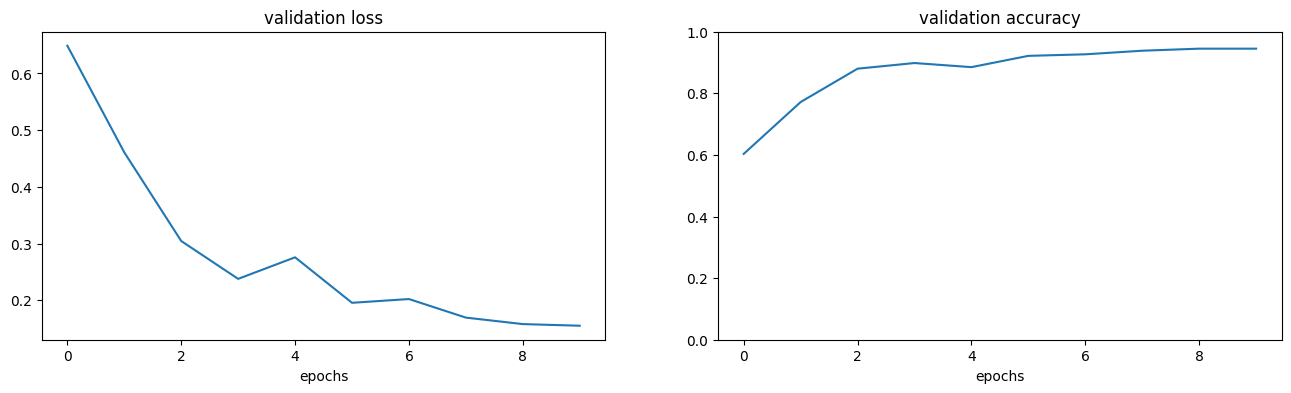

In [43]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a aumentar após cerca de 16 períodos, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a apresentar overfitting por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado precocemente por volta dessa época. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente menor.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [44]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.15770858526229858
Test accuracy: 0.9333333373069763


Por fim, vemos que alcançamos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6.000 imagens, considerando que, se tivéssemos usado uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

## Aprendizado de transferência começando com a rede existente

Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, precisará aguardar um pouco para que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar as camadas novamente com o método `summary()`.

In [45]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [46]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos retreinar esta rede, `model_new`, no novo conjunto de dados e rótulos. Mas, primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam razoavelmente relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador `trainable` em cada camada como falso (exceto em nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos na camada final. Em alguns casos, é desejável *não* congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas do VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de características, temendo que o ajuste fino excessivo neste conjunto de dados possa causar overfitting. Mas talvez estejamos errados? Um bom exercício seria testar ambos e comparar os resultados.

Então, congelamos as camadas e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para uma comparação justa. Em seguida, executamos `summary` novamente para analisar a arquitetura da rede.

In [47]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1.000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que representa apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também monitoramos seu histórico à medida que avançamos.

In [48]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 881ms/step - accuracy: 0.6710 - loss: 0.5518 - val_accuracy: 0.9583 - val_loss: 0.2339
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 804ms/step - accuracy: 0.9373 - loss: 0.2178 - val_accuracy: 0.9567 - val_loss: 0.1608
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 800ms/step - accuracy: 0.9456 - loss: 0.1675 - val_accuracy: 0.9650 - val_loss: 0.1351
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 801ms/step - accuracy: 0.9482 - loss: 0.1456 - val_accuracy: 0.9650 - val_loss: 0.1265
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 799ms/step - accuracy: 0.9539 - loss: 0.1332 - val_accuracy: 0.9683 - val_loss: 0.1159
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 801ms/step - accuracy: 0.9578 - loss: 0.1217 - val_accuracy: 0.9733 - val_loss: 0.1035
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 803ms/step - accuracy: 0.9571 - loss: 0.1216 - val_accuracy: 0.9633 - val_loss: 0.1061
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 802ms/step - accuracy: 0.9574 - loss: 0.1220 - val_accu

Nossa precisão de validação gira em torno de 80% no final, o que representa uma melhoria de mais de 30% em relação à rede original treinada do zero (o que significa que fizemos a previsão errada em 20% das amostras, em vez de 50%).

Vale a pena notar também que esta rede, na verdade, treina _um pouco mais rápido_ do que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque o congelamento dos pesos elimina a necessidade de retropropagação por todas essas camadas, economizando tempo de execução.

Vamos plotar a perda e a precisão da validação novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

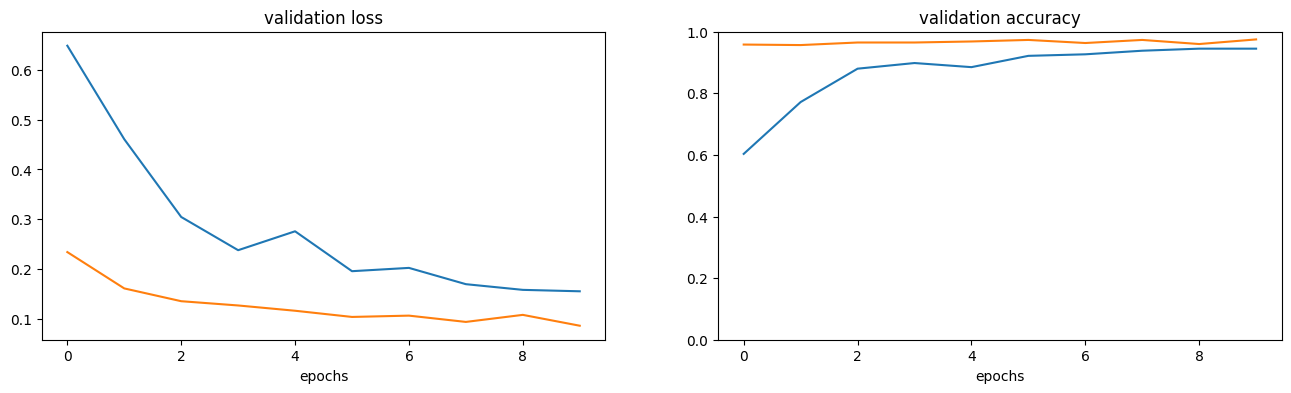

In [49]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a apresentar overfitting por volta da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado ligeiramente sua precisão com mais iterações. O novo modelo atingiu aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente ao longo de 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais dropouts, mas certamente não teríamos recuperado a melhoria de mais de 30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [50]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.08151497691869736
Test accuracy: 0.9766666889190674


To predict a new image, simply run the following code to get the probabilities for each class.

In [51]:
img, x = get_image('/content/baixados (1).jpeg')
probabilities = model_new.predict(x)
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
[[1.9516897e-07 9.9999976e-01]]


### Melhorando os resultados

78,2% de precisão top-1 em 97 classes, distribuídas de forma aproximadamente uniforme, é uma conquista bastante boa. Não é tão impressionante quanto o VGG16 original, que atingiu 73% de precisão top-1 em 1.000 classes. No entanto, é muito melhor do que conseguimos com nossa rede original, e há espaço para melhorias. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho.

- Usando a ampliação de dados: ampliação refere-se ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, alterações de iluminação, etc., para aumentar o tamanho do conjunto de treinamento e criar mais tolerância a tais distorções.
- Usando um otimizador diferente, adicionando mais regularização/dropout e outros hiperparâmetros.

- Treinamento por mais tempo (é claro)

Um exemplo mais avançado de aprendizagem por transferência no Keras, envolvendo aumento para um pequeno conjunto de dados de duas classes, pode ser encontrado no [blog do Keras](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).